<a href="https://colab.research.google.com/github/datakind/hxl-metadata-prediction/blob/main/openai-hxl-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook provides examples of predicting HXL tags and attributes by (i) Fine-tuning GPT-4o; (ii) Direct prompting using the HXL standard.




# Key findings

Fine-tuning an LLM to predict HXL tags is low-cost, but it constrained by the training data. Many datasets tagged with HXL has used tags and attributes which are not part of the HXL standard, and though there is good representation of tags and attributes related to location and dates, which are indeed very useful, beyond this coverage is poor. These challenges in the training data limit the scenarios in which the LLM fine-tuning technique can be applied.

However, in recent months there have been significant advances in LLMs, for example with the release of GPT-4o. Using this model, prompted with the full HXL standard definitions, it was shown that performance is better than fine-tuning and in some cases better than the humans who tagged the training data.

A simple class is created at the end of this notebook for predicting HXL tags on a dataframe using GPT-4o.



# Setup

See [README](README.md) for instructions.

In [ ]:
!pip install pandas==2.2.2
!pip install openai==1.35.3
!pip install python-dotenv==1.0.1

In [7]:
import openai
import os
import time
import openai
from openai import OpenAI
import pandas as pd
import json
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import sys
import requests
import pprint
import ast

from dotenv import load_dotenv
load_dotenv()

if os.getenv("OPENAI_API_KEY") is None:
  from google.colab import userdata
  OPENAI_API_KEY =  userdata.get('OPENAI_API_KEY')
else:
  OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

client = OpenAI(
    api_key=OPENAI_API_KEY
)

# If using Colab, this is where Google drive gets mounted. Otherwise leave blank
GOOGLE_BASE_DIR = "/content/drive/MyDrive/Colab"

# This is the HXL schema sheet, search HDX to get this link
HXL_SCHEMA_RESOURCE_URL = "https://docs.google.com/spreadsheets/d/1En9FlmM8PrbTWgl3UHPF_MXnJ6ziVZFhBbojSJzBdLI/export?format=xlsx"

# Where to save local data files
LOCAL_DATA_DIR = f"{GOOGLE_BASE_DIR}/hxl-metadata-prediction/data/"

# As generated by generate-test-train-data.ipynb
TRAINING_FILE = f"{LOCAL_DATA_DIR}/hxl_chat_prompts_train.jsonl"
TEST_FILE = f"{LOCAL_DATA_DIR}/hxl_chat_prompts_test.jsonl"
ALL_DATA_SHEET = f"{LOCAL_DATA_DIR}/hxl_hash_resources_data.csv"

# Base model to fine-tune
MODEL = "gpt-4o-mini-2024-07-18"

pd.set_option('display.max_colwidth', 900)
pd.set_option('display.max_rows', 50)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download HXL Schema

In [4]:
local_data_file = LOCAL_DATA_DIR + "/hxl-core-schema.xlsx"

response = requests.get(HXL_SCHEMA_RESOURCE_URL)
with open(local_data_file, 'wb') as f:
    f.write(response.content)

df= pd.read_excel(local_data_file, sheet_name='Core hashtags')
hashtags_list = df['Hashtag'][1:].tolist()

df= pd.read_excel(local_data_file, sheet_name='Core attributes')
attributes_list = df['Attribute'][1:].tolist()

# Remove rows with disallowed tags or attributes
APPROVED_HXL_SCHEMA = hashtags_list + attributes_list

print("Approved HXL schema ...")
print(APPROVED_HXL_SCHEMA)

Approved HXL schema ...
['#access', '#activity', '#adm1', '#adm2', '#adm3', '#adm4', '#adm5', '#affected', '#beneficiary', '#capacity', '#cause', '#channel', '#contact', '#country', '#crisis', '#currency', '#date', '#delivery', '#description', '#event', '#frequency', '#geo', '#group', '#impact', '#indicator', '#inneed', '#item', '#loc', '#meta', '#modality', '#need', '#operations', '#org', '#output', '#population', '#reached', '#region', '#respondee', '#sector', '#service', '#severity', '#status', '#subsector', '#targeted', '#value', '+abducted', '+acronym', '+activity', '+adolescents', '+adults', '+approved', '+ar', '+bounds', '+budget', '+canceled', '+children', '+cluster', '+code', '+converted', '+coord', '+dest', '+displaced', '+elderly', '+elevation', '+email', '+en', '+end', '+es', '+f', '+fa', '+fr', '+funder', '+hh', '+i', '+id', '+idps', '+impl', '+incamp', '+ind', '+infants', '+infected', '+injured', '+killed', '+label', '+lat', '+lon', '+m', '+ms', '+name', '+noncamp', '+num

# Analysis

## Check test/train

Let's do a sanity check to ensure the test set doesn't include data from orgnaizations in the traning set.

## Fine-tune

In [5]:
def fine_tune_model(train_file, model_name="gpt-4o-mini"):
    """
    Fine-tune an OpenAI model using training data.

    Args:
        prompt_file (str): The file containing the prompts to use for fine-tuning.
        model_name (str): The name of the model to fine-tune. Default is "davinci-002".

    Returns:
        str: The ID of the fine-tuned model.
    """

    # Upload file to OpenAI for fine-tuning
    file = client.files.create(
        file=open(train_file, "rb"),
        purpose="fine-tune"
    )
    file_id = file.id
    print(f"Uploaded training file with ID: {file_id}")

    # Start the fine-tuning job
    ft = client.fine_tuning.jobs.create(
        training_file=file_id,
        model=model_name
    )
    ft_id = ft.id
    print(f"Fine-tuning job started with ID: {ft_id}")

    # Monitor the status of the fine-tuning job
    ft_result = client.fine_tuning.jobs.retrieve(ft_id)
    while ft_result.status != 'succeeded':
        print(f"Current status: {ft_result.status}")
        time.sleep(120)  # Wait for 60 seconds before checking again
        ft_result = client.fine_tuning.jobs.retrieve(ft_id)
        if 'failed' in ft_result.status.lower():
            sys.exit()

    print(f"Fine-tuning job {ft_id} succeeded!")

    # Retrieve the fine-tuned model
    fine_tuned_model = ft_result.fine_tuned_model
    print(f"Fine-tuned model: {fine_tuned_model}")

    return fine_tuned_model

In [8]:
def read_prompts_file(filename):
  results = []
  with open(filename) as f:
    prompts = [json.loads(line) for line in f]
    for p in prompts:
      p["prompt"] = p["messages"][0:2]
      p["expected"] = p["messages"][-1]["content"]
      results.append(p)
    results = pd.DataFrame(results)

    print(f"\nFound {len(results)} prompts")

    results['tag'] = results['expected'].apply(lambda x: x.split('+')[0])
    tag_counts = results['tag'].value_counts()
    print("\n",tag_counts)

  return results

print("\n\n======= TRAIN =======")
X_train = read_prompts_file(TRAINING_FILE)
print("\n\n======= TRAIN =======")
X_test = read_prompts_file(TEST_FILE)

display(X_train)



======= TRAIN =======

Found 2883 prompts

 tag
#adm1           485
#adm2           436
#affected       337
#country        211
#date           202
#org            186
#adm3           172
#inneed         140
#geo            103
#sector          91
#targeted        75
#activity        54
#loc             52
#population      52
#status          45
#indicator       35
#reached         31
#adm4            30
#meta            21
#region          21
#value           11
#item            10
#subsector       10
#beneficiary      9
#event            9
#severity         8
#cause            7
#currency         4
#access           4
#contact          4
#crisis           4
#service          4
#adm5             4
#capacity         3
#impact           3
#group            2
#modality         2
#output           2
#delivery         1
#frequency        1
#description      1
#operations       1
Name: count, dtype: int64


======= TRAIN =======

Found 458 prompts

 tag
#country        73
#affected       

,messages,prompt,expected,tag
0,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/DRC - Baseline Assessment - M23 Crisis 13 - February 20248.xlsx'; dataset_description='The dataset from the file ""DRC - Baseline Assessment - M23 Crisis 13 - February 20248.xlsx"" contains information on the total number of internally displaced persons (IDPs) and returnees in the Democratic Republic of Congo. The data includes the total number of IDP households, individual IDPs, male and female IDPs, and returnees. For instance, there are 319,283 IDP households, 1,548,732 individual IDPs, 646,805 male IDPs, 901,927 female IDPs, and 587,705 returnees.'; column_name:'Total IDP HH'; examples: [319283]'}, {'r...","[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/DRC - Baseline Assessment - M23 Crisis 13 - February 20248.xlsx'; dataset_description='The dataset from the file ""DRC - Baseline Assessment - M23 Crisis 13 - February 20248.xlsx"" contains information on the total number of internally displaced persons (IDPs) and returnees in the Democratic Republic of Congo. The data includes the total number of IDP households, individual IDPs, male and female IDPs, and returnees. For instance, there are 319,283 IDP households, 1,548,732 individual IDPs, 646,805 male IDPs, 901,927 female IDPs, and 587,705 returnees.'; column_name:'Total IDP HH'; examples: [319283]'}]",#affected+hh,#affected
1,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/DRC - Baseline Assessment - M23 Crisis 13 - February 20248.xlsx'; dataset_description='The dataset from the file ""DRC - Baseline Assessment - M23 Crisis 13 - February 20248.xlsx"" contains information on the total number of internally displaced persons (IDPs) and returnees in the Democratic Republic of Congo. The data includes the total number of IDP households, individual IDPs, male and female IDPs, and returnees. For instance, there are 319,283 IDP households, 1,548,732 individual IDPs, 646,805 male IDPs, 901,927 female IDPs, and 587,705 returnees.'; column_name:'Total Returnees'; examples: [587705]'}, ...","[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/DRC - Baseline Assessment - M23 Crisis 13 - February 20248.xlsx'; dataset_description='The dataset from the file ""DRC - Baseline Assessment - M23 Crisis 13 - February 20248.xlsx"" contains information on the total number of internally displaced persons (IDPs) and returnees in the Democratic Republic of Congo. The data includes the total number of IDP households, individual IDPs, male and female IDPs, and returnees. For instance, there are 319,283 IDP households, 1,548,732 individual IDPs, 646,805 male IDPs, 901,927 female IDPs, and 587,705 returnees.'; column_name:'Total Returnees'; examples: [587705]'}]",#affected+ind+returnees,#affected
2,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/admin1-summaries-earthquake8.csv'; dataset_description='The dataset con

In [9]:
model = fine_tune_model(TRAINING_FILE, model_name=MODEL)

Uploaded training file with ID: file-u6rzCdioOsDYp4S8ewAHDFIq
Fine-tuning job started with ID: ftjob-H53bd8Bd3UNnsnYZBELh2Ege
Current status: validating_files
Current status: validating_files
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Current status: running
Fine-tuning job ftjob-H53bd8Bd3UNnsnYZBELh2Ege succeeded!
Fine-tuned model: ft:gpt-4o-mini-2024-07-18:datakind::9r934Xcy


In [68]:
#model = "ft:gpt-4o-mini-2024-07-18:datakind::9oJXzcfa" # No data summaries
#model = "ft:gpt-4o-mini-2024-07-18:datakind::9p1xodpF # With data description"
model = "ft:gpt-4o-mini-2024-07-18:datakind::9r934Xcy"
print(f"Fine-tuned model: {model}")

Fine-tuned model: ft:gpt-4o-mini-2024-07-18:datakind::9r934Xcy


## Prediction Test

In [10]:
def make_chat_predictions(prompts, model, temperature=0.1, max_tokens=13):
  results = []
  for p in prompts:
    actual = p["messages"][-1]["content"]
    p["messages"] = p["messages"][0:2]
    completion = client.chat.completions.create(
      model=model,
      messages=p["messages"],
      temperature=temperature,
      max_tokens=max_tokens
    )
    predicted = completion.choices[0].message.content
    predicted = filter_for_schema(predicted)

    res = {
        "prompt": p["messages"],
        "actual": actual,
        "predicted": predicted
    }

    print(f"Predicted: {predicted}; Actual: {actual}")

    results.append(res)

  results = pd.DataFrame(results)

  return results

def filter_for_schema(text):
    #print(f"Tokens before: {text}")
    if " " in text:
        text = text.replace(" ","")

    tokens_raw = text.split("+")
    tokens = [tokens_raw[0]]
    for t in tokens_raw[1:]:
        tokens.append(f"+{t}")

    filtered = []
    for t in tokens:
        if t in APPROVED_HXL_SCHEMA:
            if t not in filtered:
                filtered.append(t)
    filtered = "".join(filtered)

    if len(filtered) > 0 and filtered[0] != '#':
        filtered = ""

    return filtered

def output_prediction_metrics(results, prediction_field="predicted", actual_field="actual"):
    """
    Prints out model performance report for HXL tag prediction. Metrics are for
    just predicting tags, as well as predicting tags and attributes.

    Parameters
    ----------
    results : dataframe
        Dataframe of results
    prediction_field : str
        Field name of element with prediction. Handy for comparing raw and post-processed predictions.
    actual_field: str
        Field name of the actual result for comparison with prediction
    """
    y_test = []
    y_pred = []
    y_justtag_test = []
    y_justtag_pred = []
    for index, r in results.iterrows():
        if actual_field not in r and predicted_field not in r:
            print("Provided results do not contain expected values.")
            sys.exit()
        y_pred.append(r[prediction_field])
        y_test.append(r[actual_field])
        actual_tag = r[actual_field].split("+")[0]
        predicted_tag = r[prediction_field].split("+")[0]
        y_justtag_test.append(actual_tag)
        y_justtag_pred.append(predicted_tag)

    print(f"LLM results for {prediction_field}, {len(results)} predictions ...")
    print("\nJust HXL tags ...\n")
    print(f"Accuracy: {round(accuracy_score(y_justtag_test, y_justtag_pred),2)}")
    print(
        f"Precision: {round(precision_score(y_justtag_test, y_justtag_pred, average='weighted', zero_division=0),2)}"
    )
    print(
        f"Recall: {round(recall_score(y_justtag_test, y_justtag_pred, average='weighted', zero_division=0),2)}"
    )
    print(
        f"F1: {round(f1_score(y_justtag_test, y_justtag_pred, average='weighted', zero_division=0),2)}"
    )

    print(f"\nTags and attributes with {prediction_field} ...\n")
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred),2)}")
    print(
        f"Precision: {round(precision_score(y_test, y_pred, average='weighted', zero_division=0),2)}"
    )
    print(
        f"Recall: {round(recall_score(y_test, y_pred, average='weighted', zero_division=0),2)}"
    )
    print(
        f"F1: {round(f1_score(y_test, y_pred, average='weighted', zero_division=0),2)}"
    )

    return

In [11]:
with open(TEST_FILE) as f:
    X_test = [json.loads(line) for line in f]

# Subsample
#size = 10
#X_test = X_test[-size:]

results = make_chat_predictions(X_test, model)

results.to_excel(f"{LOCAL_DATA_DIR}/hxl-metadata-prediction-results.xlsx", index=False)

display(results)

output_prediction_metrics(results)

print("Done")

Predicted: #beneficiary+ind; Actual: #meta+id
Predicted: ; Actual: #crisis+name
Predicted: #meta+id; Actual: #cause+id
Predicted: #crisis+type; Actual: #cause+name
Predicted: #status; Actual: #status+code
Predicted: #status+name; Actual: #status+name
Predicted: #date+start; Actual: #date+start
Predicted: #date+end; Actual: #date+end
Predicted: #country+code; Actual: #country+code
Predicted: #country+name; Actual: #country+name
Predicted: #adm1+code; Actual: #region+id
Predicted: #region+name; Actual: #region+name
Predicted: #country+name; Actual: #country+name
Predicted: #country+code; Actual: #country+code
Predicted: #adm1+name; Actual: #loc+name
Predicted: #meta+id; Actual: #meta+id
Predicted: #indicator+name; Actual: #indicator+name
Predicted: #country+name; Actual: #country+name
Predicted: #indicator+id; Actual: #indicator+code
Predicted: #indicator+type; Actual: #indicator+code+label
Predicted: #country+code; Actual: #country+code
Predicted: #meta+id; Actual: #meta+id
Predicted: #

,prompt,actual,predicted
0,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#meta+id,#beneficiary+ind
1,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#crisis+name,
2,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#cause+id,#meta+id
3,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#cause+name,#crisis+type
4,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; d

LLM results for predicted, 458 predictions ...

Just HXL tags ...

Accuracy: 0.83
Precision: 0.85
Recall: 0.83
F1: 0.82

Tags and attributes with predicted ...

Accuracy: 0.61
Precision: 0.6
Recall: 0.61
F1: 0.57
Done


### Prediction analysis


Next we will look at cases where the prediction failed to see patterns to address.

In [21]:
results["match"] = results['predicted'] == results['actual']
display(results[results["match"]==False])
breaks = results[results["match"]==False]
print(breaks.shape)


,prompt,actual,predicted,tag,match
0,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#meta+id,#beneficiary+ind,#meta,False
1,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#crisis+name,,#crisis,False
2,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#cause+id,#meta+id,#cause,False
3,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#cause+name,#crisis+type,#cause,False
4,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metad

(178, 5)


#### Scenario 1 - Predicting 'adm1' human labelled region



In [22]:
# Find rows where match is False and predicted contains admin1
scenario1 = breaks[(breaks["match"]==False) & (breaks["actual"].str.contains("region")) & (breaks["predicted"].str.contains("adm1"))]
display(scenario1)
print(scenario1.shape)

,prompt,actual,predicted,tag,match
10,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#region+id,#adm1+code,#region,False
51,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/Burundi- Muyinga, Cankuzo, Makamba, Ruyigi, Rutana, Rumonge: Operational Presence3.xlsx'; dataset_description='nan'; column_name:'Region'; examples: ['Muyinga', 'Muyinga', 'Muyinga', 'Muyinga', 'Cankuzo', 'Rumonge', 'Ruyigi', 'Ruyigi', 'Makamba', 'Makamba', 'Rutana']'}]",#region+name,#adm1+name,#region,False
68,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/2014-2018 - Somalia Death Rates3.xlsx'; dataset_description='The dataset contains information on death rates in various regions of Somalia from 2014 to 2018. It includes data such as the state, region, district, crude death rate, and under 5 years death rate. Each entry specifies the state, region, district, and corresponding death rates for both crude deaths and deaths under 5 years of age. The dataset provides a snapshot of mortality rates in different areas of Somalia over the specified time period.'; column_name:'STATE'; examples: ['Hirshabelle', 'South West', 'Jubaland', 'Jubaland', 'Jubaland', 'Som...",#region+name,#adm1+name,#region,False
109,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/NGA_Subnational_Covid19_HXL_HERA3.csv'; dataset_description='The dataset contains information on COVID-19 cases in different regions of Nigeria, with columns including ID, date, ISO code, country name, region name, number of confirmed cases, deaths, recoveries, and gender breakdown of cases. The data is sourced from the Nigeria Centre for Disease Control and covers various regions such as Abia, Adamawa, Akwa Ibom, Anambra, Bauchi, Bayelsa, Benue, Borno, and Cross River. The dataset appears to be structured with semicolons as delimiters and includes specific details for each region's COVID-19 situation.';...",#region+name,#adm1+name,#region,False
115,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/BFA_Subnational_Covid19_HXL_HERA3.csv'; dataset_description='The dataset contains information on COVID-19 cases in Burkina Faso at a subnational level, with columns including ID, DATE, ISO_3, PAYS, ID_PAYS, REGION, ID_REGION, CONTAMINES, DECES, GUERIS, and various vaccination-related data. Each row rep

(17, 5)


The columns in these cases are called 'Region' so using '#region' as the tag seems perfectly reasonable. However, for some countries region is in fact the administrative level 1. Looking at the two examples above, "Ruyigi", "Muyinga" and "Makamba" are in fact administrative level 1, same applies for the other 'incorrect' predictions in this category. Basically, both the human-labelled data and the different LLM prediction are correct.
What's interesting here is that 'adm1' is perhaps a more consistent classification as it is more commonly used in linking datasets.

#### Scenario 2 - When labeled data says admin1 but really it is country (admin 0)

In [23]:
breaks = breaks[~breaks.index.isin(scenario1.index)]
print(breaks.shape)

scenario2 = breaks[(breaks["predicted"].str.contains("country")) & (breaks["actual"].str.contains("adm1"))]
display(scenario2)
print(scenario2.shape)


(161, 5)


,prompt,actual,predicted,tag,match
50,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/Burundi- Muyinga, Cankuzo, Makamba, Ruyigi, Rutana, Rumonge: Operational Presence3.xlsx'; dataset_description='nan'; column_name:'Country'; examples: ['Burundi', 'Burundi', 'Burundi', 'Burundi', 'Burundi', 'Burundi', 'Burundi', 'Burundi', 'Burundi', 'Burundi', 'Burundi']'}]",#adm1+name,#country+name,#adm1,False
81,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/FieldsData_3W_PHL_Aklan3.xlsx'; dataset_description='nan'; column_name:'Country'; examples: ['Philippines', 'Philippines', 'Philippines', 'Philippines', 'Philippines', 'Philippines', 'Philippines', 'Philippines', 'Philippines', 'Philippines', 'Philippines']'}]",#adm1+name,#country+name,#adm1,False
139,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/Kerela3.xlsx'; dataset_description='The dataset from the file ""Kerela3.xlsx"" contains information about different organizations, their activities, and locations in Kerala, India. The data includes timestamps, source names, organization names, types of organizations, regions, countries, provinces, and sectors of focus. The organizations mentioned are Totem Resource Centre and Neethi Vedhi, engaging in various sectors such as education, health & nutrition, livelihoods, environment protection, food security, and protection. The data seems to capture activities related to social welfare and development in th...",#adm1+name,#country,#adm1,False
181,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/Burundi Cankuzo_FD3.xlsx'; dataset_description='The dataset from the file ""Burundi Cankuzo_FD3.xlsx"" contains information on various organizations operating in the Cankuzo region of Burundi. The data includes details such as the timestamp, data source, organization name, region, country, province, and sector of operation. Organizations mentioned in the dataset are involved in sectors like food security, protection, SGBV (Sexual and Gender-Based Violence), health, environment protection, and nutrition. The dataset seems to capture data entries from different dates, with each entry providing specific infor...",#adm1+name,#country,#adm1,False
209,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/4W_BU_Kayanza2.csv'; dataset_description='The dataset contains information on various organizations operating in Kayanza, Burundi, including CARE International, World Food Program, Action Aid, Fédération Nationale des Associations engagées dans le Domaine de l'Enfance au Burundi (FENADEB), Initiative Pastorale pour la Réinsertion des Enfants en Difficulté (IPRED), Observatoire INEZA des droits de l'enfant au Burundi (OIDEB), and Red Cross - Burundi. The organizations are involved in sectors such as education, food security, and child protection, with activities ranging from development to humanitarian ai...",#adm1+name,#country+name,#adm1,False
218,"[{

(7, 5)


The model is correct here, the column names are typically things like 'Country'.

#### Scenario 3 - Where prediction adds 'name' but labeled data doesn't have attribute

In [24]:
breaks = breaks[~breaks.index.isin(scenario2.index)]
print(breaks.shape)

scenario3 = breaks[(breaks["predicted"].str.len() > breaks["actual"].str.len()) & (breaks["predicted"].str.contains("name"))]
display(scenario3)
print(scenario3.shape)

(154, 5)


,prompt,actual,predicted,tag,match
14,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/DHS Quickstats Data for Sao Tome and Principe6.csv'; dataset_description='The dataset contains information on various indicators related to health and demographics in Sao Tome and Principe, with data points for different regions within the country. The indicators include total fertility rate for women aged 15-49, percentage of married women currently using contraception, and percentage of married women using modern contraception methods. The data includes values, precision, survey details, and characteristic categories for each indicator. The dataset covers the year 2008 and is sourced from the DHS (Demo...",#loc+name,#adm1+name,#loc,False
37,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/OxCGRT_CSV3.csv'; dataset_description='The dataset contains information on various measures and indicators related to COVID-19 response for different countries and regions. It includes data such as government responses, containment measures, economic support, vaccination policies, confirmed cases, confirmed deaths, majority vaccinated status, population vaccinated, stringency index, and other related indices. The data is structured with columns representing different aspects of the response measures and indicators, with rows corresponding to specific dates and locations.'; column_name:'CountryName'; exam...",#country,#country+name,#country,False
57,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for Uzbekistan3.csv'; dataset_description='The dataset contains information on IFRC appeals data for Uzbekistan, including details such as appeal ID, name, type, status, sector, funding amounts, start and end dates, and country information. The data includes appeals related to population movement, explosions, drought, and general assistance in Uzbekistan. The dataset also includes details on the organization involved, such as the Red Crescent Society of Uzbekistan, as well as information on the region, beneficiaries, and confirmation status.'; column_name:'name'; examples: ['Uzbekistan ...",#crisis+name,#activity+name,#crisis,False
94,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IATI activities in Nepal3.csv'; dataset_description='The dataset contains information on various aid activities in Nepal, including details such as activity ID, reporting organizations, start and end dates, descriptions, funding amounts in different currencies, country allocation percentages, sector information, and location details. The activities are implemented by organizations like the United Nations Development Programme, Gavi, The Vaccine Alliance, Drugs for Neglected Diseases initiative, and UN Pooled Funds. The dataset also includes links to additional information for each activity.'; column_name...",#sector,#sector+name,#sector,False
272,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDriv

(29, 5)


Looking at the above, apart from two real breaks, the rest seem to be correct. The model is adding 'name' for what are name columns.

#### The rest

In [25]:
breaks = breaks[~breaks.index.isin(scenario3.index)]
print(breaks.shape)
display(breaks)
print(breaks.shape)

(125, 5)


,prompt,actual,predicted,tag,match
0,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#meta+id,#beneficiary+ind,#meta,False
1,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#crisis+name,,#crisis,False
2,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#cause+id,#meta+id,#cause,False
3,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#cause+name,#crisis+type,#cause,False
4,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metad

(125, 5)


The above is a bit of a mixed bag ...

- Some cases where the model is incorrect, typically where the model did not have enough context in the prompt. For example, rows above where actual is "#org" and predicted varies. The excel sheet has more surrounding context than provided to the model.

- There are also cases where the model seems reasonable (eg #beneficiary+type for column "Beneficiary type", #activity+type for column "Type of Activity").

- Administrative level disagreements, eg 'Province' column name where actual is #adm2+name, but the model predicts province as #adm1+name.

- Various other mismatches around tag order, differing granularity of tags and more

The takeaway for the exceptions is that in most cases, it's the human-labeled data that could be improved.

## Human review of prediction fails

Let's create a spreadsheet for human-review of the failed predictions.

In [32]:
# Read supporting metadata
results.to_excel(f"{LOCAL_DATA_DIR}/hxl-metadata-fine-tune-prediction-results.xlsx", index=False)


Looking at the [human reviewed](https://docs.google.com/spreadsheets/d/1QhRJX-Z4m3DHG9UoSKn5RbAS6Mz2v-11JxfvLI0CYK8/edit?usp=sharing) sheet, many of the prediction differences are cases where the LLM prediction is actually correct.

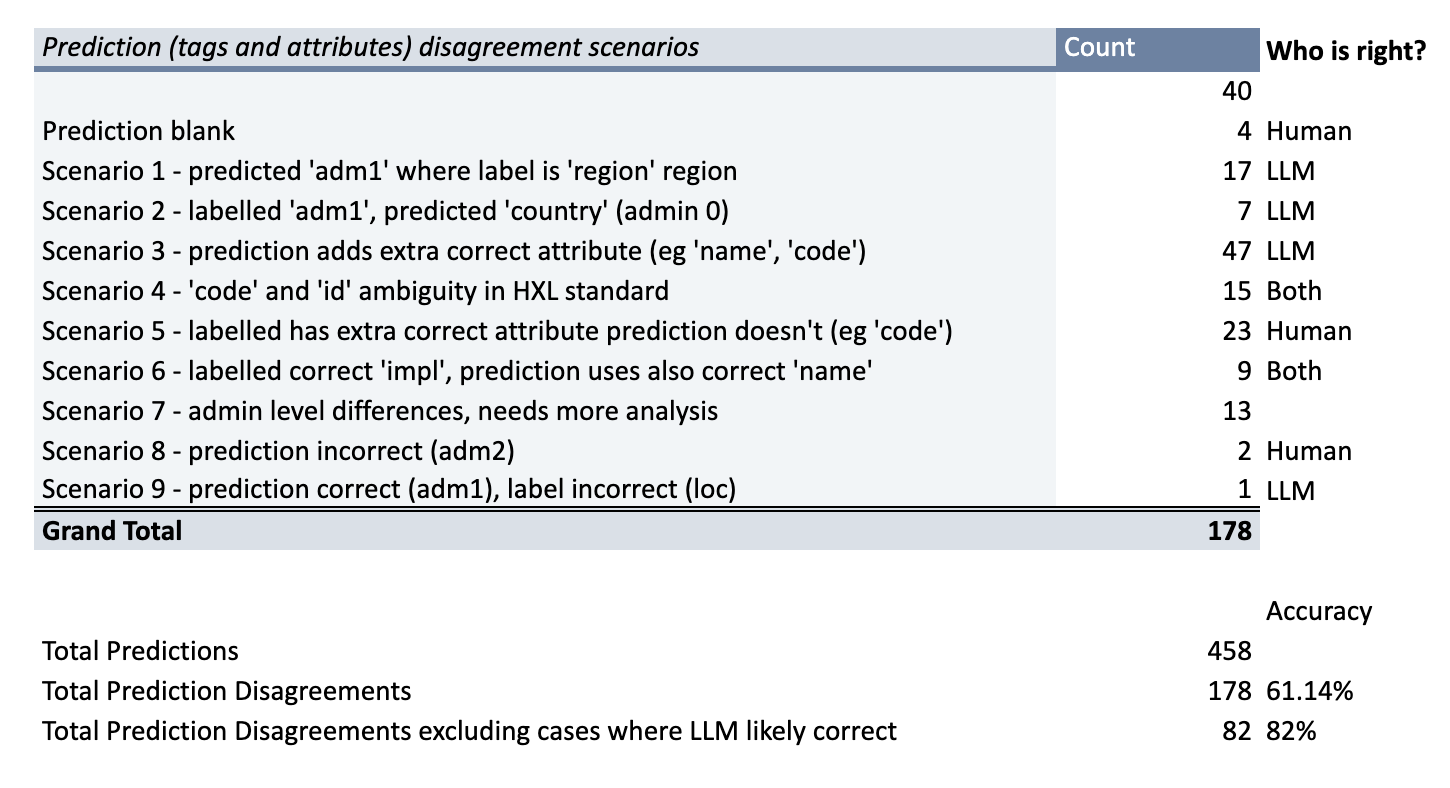



The above is a very quick review, no doubt these figures could be refined, but there are two takeaways:

- The human labelled data is not always correct, and so might not always be good for traning and testing
- Though the LLM prediction is not perfect, given the high-cardinality of tags + attributes, performance is actually acceptable.

## Correcting the test data for mislabelled HXL and re-running predictions

Given the above analysis, we should correct the test data and run the prediction again. This was done manually in the [human reviewed](https://docs.google.com/spreadsheets/d/1QhRJX-Z4m3DHG9UoSKn5RbAS6Mz2v-11JxfvLI0CYK8/edit?usp=sharing) sheet.


In [71]:
# Read hxl-metadata-fine-tune-prediction-results-review.xls, first tab
X_test2 = pd.read_excel(f"{LOCAL_DATA_DIR}/hxl-metadata-fine-tune-prediction-results-review.xlsx", sheet_name=0)

def make_chat_predictions(prompts, model, temperature=0.1, max_tokens=13, actual_field="actual"):
  results = []
  for index, row in prompts.iterrows():
    prompt = row["prompt"]
    prompt = ast.literal_eval(prompt)

    actual = row[actual_field]
    completion = client.chat.completions.create(
        model=model,
        messages=prompt,
        temperature=temperature,
        max_tokens=max_tokens
    )
    predicted = completion.choices[0].message.content
    predicted = filter_for_schema(predicted)

    res = {
        "prompt": prompt,
        "actual": actual,
        "predicted": predicted
    }

    print(f"Predicted: {predicted}; Actual: {actual}")

    results.append(res)

  results = pd.DataFrame(results)
  return results

results = make_chat_predictions(X_test2, model, temperature=0.1, max_tokens=13, \
                                actual_field = "Corrected actual")

results.to_excel(f"{LOCAL_DATA_DIR}/hxl-metadata-prediction-corrected-test-results.xlsx", \
                 index=False)

display(results)

output_prediction_metrics(results)


Predicted: #beneficiary+ind; Actual: #meta+id
Predicted: ; Actual: #crisis+name
Predicted: #meta+id; Actual: #cause+id
Predicted: #crisis+type; Actual: #cause+name
Predicted: #status; Actual: #status+code
Predicted: #status+name; Actual: #status+name
Predicted: #date+start; Actual: #date+start
Predicted: #date+end; Actual: #date+end
Predicted: #country+code; Actual: #country+code
Predicted: #country+name; Actual: #country+name
Predicted: #adm1+code; Actual: #adm1+code
Predicted: #region+name; Actual: #region+name
Predicted: #country+name; Actual: #country+name
Predicted: #country+code; Actual: #country+code
Predicted: #loc+name; Actual: #loc+name
Predicted: #meta+id; Actual: #meta+id
Predicted: #indicator+name; Actual: #indicator+name
Predicted: #country+name; Actual: #country+name
Predicted: #indicator+id; Actual: #indicator+id
Predicted: #indicator+type; Actual: #indicator+code+label
Predicted: #country+code; Actual: #country+code
Predicted: #meta+id; Actual: #meta+id
Predicted: #ind

,prompt,actual,predicted
0,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#meta+id,#beneficiary+ind
1,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#crisis+name,
2,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#cause+id,#meta+id
3,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; dataset_description='The dataset contains information on various appeals and events related to South Sudan, including details such as the type of appeal, status, sector, amount requested and funded, start and end dates, as well as country-specific information like country code, region, and average household size. The data includes appeals for different crises such as floods, population movements, cholera outbreaks, and Ebola preparedness, with details on beneficiaries and confirmation needs. The dataset also includes metadata such as IDs, names, and translation mo...",#cause+name,#crisis+type
4,"[{'role': 'system', 'content': ' You are an assistant that replies with HXL tags and attributes"" '}, {'role': 'user', 'content': 'What are the HXL tags and attributes for a column with these details? resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC Appeals Data for South Sudan8.csv'; d

LLM results for predicted, 458 predictions ...

Just HXL tags ...

Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1: 0.88

Tags and attributes with predicted ...

Accuracy: 0.66
Precision: 0.71
Recall: 0.66
F1: 0.66


## Just prompts, no fine-tuning



In [84]:
def generate_hxl_standard_prompt(local_data_file):

  core_hashtags = pd.read_excel(local_data_file, sheet_name='Core hashtags')
  core_hashtags = core_hashtags.loc[core_hashtags["Release status"] == "Released"]
  core_hashtags = core_hashtags[["Hashtag", "Hashtag long description", "Sample HXL"]]

  core_attributes = pd.read_excel(local_data_file, sheet_name='Core attributes')
  core_attributes = core_attributes.loc[core_attributes["Status"] == "Released"]
  core_attributes = core_attributes[["Attribute", "Attribute long description", "Suggested hashtags (selected)"]]

  print(core_hashtags.shape)
  print(core_attributes.shape)

  core_hashtags = core_hashtags.to_dict(orient='records')
  core_attributes = core_attributes.to_dict(orient='records')

  hxl_prompt= f"""
  You are an AI assistant that predicts Humanitarian Markup Language (HXL) tags and attributes for columns of data where the HXL standard is defined as follows:

  CORE HASHTAGS:

  {json.dumps(core_hashtags,indent=4)}

  CORE ATTRIBUTES:

  {json.dumps(core_attributes, indent=4)}

  Key points:

  - ALWAYS predict hash tags
  - NEVER predict a tag which is not a valid core hashtag
  - NEVER start with a core hashtag, you must always start with a core hashtag
  - Always try and predict an attribute if possible
  - Do not use attribute +code if the data examples are human readable names

  You must return your result as a JSON record with the fields 'predicted' and 'reasoning', each is of type string.

  """

  print(len(hxl_prompt.split(" ")))
  print(hxl_prompt)
  return hxl_prompt

hxl_prompt = generate_hxl_standard_prompt(local_data_file)


(44, 3)
(54, 3)
5255

  You are an AI assistant that predicts Humanitarian Markup Language (HXL) tags and attributes for columns of data where the HXL standard is defined as follows:

  CORE HASHTAGS:

  [
    {
        "Hashtag": "#access",
        "Hashtag long description": "Accessiblity and constraints on access to a market, distribution point, facility, etc.",
        "Sample HXL": "#access +type"
    },
    {
        "Hashtag": "#activity",
        "Hashtag long description": "A programme, project, or other activity. This hashtag applies to all levels; use the attributes +activity, +project, or +programme to distinguish different hierarchical levels.",
        "Sample HXL": "#activity +project"
    },
    {
        "Hashtag": "#adm1",
        "Hashtag long description": "Top-level subnational administrative area (e.g. a governorate in Syria).",
        "Sample HXL": "#adm1 +code"
    },
    {
        "Hashtag": "#adm2",
        "Hashtag long description": "Second-level subnationa

In [86]:
def call_gpt(prompt, system_prompt, model, temperature, top_p, max_tokens):
    response = client.chat.completions.create(
        model=model,
        messages= [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ],
        max_tokens=2000,
        temperature=temperature,
        top_p=top_p,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None,
        stream=False,
        response_format={ "type": "json_object" }
    )

    result = response.choices[0].message.content
    result = result.replace("```json","").replace("```","")
    try:
        result = json.loads(result)
        result["predicted"] = result["predicted"].replace(" ","")
    except:
        print(result)
        result = None
    return result

def make_prompt_predictions(prompts, model, temperature=0.1, top_p=0.1, \
                            max_tokens=2000, debug=False, actual_field="actual"):

  num_prompts = len(prompts)
  print(f"Number of prompts: {num_prompts}")

  results = []
  for index, p in prompts.iterrows():

      if index % 50 == 0:
          print(f"{index/num_prompts*100:.2f}% complete")

      prompt = p["prompt"]
      prompt = ast.literal_eval(prompt)
      prompt = prompt[1]["content"]
      actual = p[actual_field]

      result = call_gpt(prompt, hxl_prompt, model, temperature, top_p, max_tokens)

      if result is None:
          print("    !!!!! No LLM result")
          predicted = ""
          reasoning = ""
      else:
          predicted = result["predicted"]
          reasoning = result["reasoning"]

      if debug is True:
        print(f"Actual: {actual}; Predicted: {predicted}; Reasoning: {reasoning}")

      results.append({
          "prompt": prompt,
          "actual": actual,
          "predicted": predicted,
          "reasoning": reasoning
      })

  results = pd.DataFrame(results)

  print(f"\n\n===================== {model} Results =========================\n\n")
  output_prediction_metrics(results)
  print(f"\n\n=================================================================")

  results["match"] = results['predicted'] == results['actual']
  results.to_excel(f"{LOCAL_DATA_DIR}/hxl-metadata-prompting-only-prediction-{model}-results.xlsx", index=False)

  return results

for model in ["gpt-4o-mini","gpt-4o"]:
  print(f"Model: {model}")
  results = make_prompt_predictions(X_test2, model, temperature=0.1, top_p=0.1, \
                                    max_tokens=2000, debug=False, \
                                    actual_field = "Corrected actual")

Model: gpt-4o-mini
Number of prompts: 458
0.00% complete
10.92% complete
21.83% complete
32.75% complete
43.67% complete
54.59% complete
65.50% complete
76.42% complete
87.34% complete
98.25% complete


===================== gpt-4o-mini Results =========================


LLM results for predicted, 458 predictions ...

Just HXL tags ...

Accuracy: 0.77
Precision: 0.83
Recall: 0.77
F1: 0.77

Tags and attributes with predicted ...

Accuracy: 0.53
Precision: 0.54
Recall: 0.53
F1: 0.5


Model: gpt-4o
Number of prompts: 458
0.00% complete
10.92% complete
21.83% complete
32.75% complete
43.67% complete
54.59% complete
65.50% complete
76.42% complete
87.34% complete
98.25% complete


===================== gpt-4o Results =========================


LLM results for predicted, 458 predictions ...

Just HXL tags ...

Accuracy: 0.86
Precision: 0.86
Recall: 0.86
F1: 0.85

Tags and attributes with predicted ...

Accuracy: 0.71
Precision: 0.7
Recall: 0.71
F1: 0.69




### Prediction analysis

As a reminder, the fine-tuned model produced the following results ...

```
LLM results for predicted, 458 predictions ...

Just HXL tags ...

Accuracy: 0.83
Precision: 0.85
Recall: 0.83
F1: 0.82

Tags and attributes with predicted ...

Accuracy: 0.61
Precision: 0.6
Recall: 0.61
F1: 0.57
```

*How does prompting-only GPT-4o compare with GPT-4o-mini?*  

Looking at the above, we see that GPT-4o-mini predicts just tags with 77% accuracy, which is less than fine-tuning (83%) and GPT-4o (86%). That said the performance is still good and would improve HXL coverage if used.

*How does prompting-only compare with the fine-tuned model?*  

GPT-4o gave the best results of all models, with 86% accuracy on tags and 71% on tags and attributes. In fact, the performance could well be better with more analysis of the test data to correct incorrect human-labelled tags, but that would be for future work.


Let's take a close look at the latter. Let's take a closer look at the latter ...

In [101]:
df = pd.read_excel(f"{LOCAL_DATA_DIR}/hxl-metadata-prompting-only-prediction-gpt-4o-results.xlsx")

breaks = df[df["match"]==False]
print(breaks.shape)

for index, row in breaks.iterrows():
  print("\n======================================== ")
  pprint.pp(f"\nPrompt: {row['prompt']}")
  print()
  print(f"Actual", row["actual"])
  print(f"Predicted", row["predicted"])
  print()
  pprint.pp(f'Reasoning: \n{row["reasoning"]}')

(133, 5)

('\n'
 'Prompt: What are the HXL tags and attributes for a column with these '
 'details? '
 "resource_name='/content/drive/MyDrive/Colab/hxl-metadata-prediction/data/IFRC "
 "Appeals Data for South Sudan8.csv'; dataset_description='The dataset "
 'contains information on various appeals and events related to South Sudan, '
 'including details such as the type of appeal, status, sector, amount '
 'requested and funded, start and end dates, as well as country-specific '
 'information like country code, region, and average household size. The data '
 'includes appeals for different crises such as floods, population movements, '
 'cholera outbreaks, and Ebola preparedness, with details on beneficiaries and '
 'confirmation needs. The dataset also includes metadata such as IDs, names, '
 "and translation modules for countries and regions.'; column_name:'dtype.id'; "
 "examples: ['12', '5', '1', '1', '12', '12', '1', '6', '1', '1', '7']")

Actual #cause+id
Predicted #meta+id

('Re

In the above, there are some examples where the model has predicted incorrectly, for example for disagreements in administrative level. With more context in the prompt, these could likely be improved, and some may even be correct predictions.

Otherwise, the remaining disagreements mostly seem to be fairly minor, cases where the actual attribute are both correct, for example ...

Actual #description+en
Predicted #description+text

And some examples where either prediction or actual go to a finer attribute granularity. On the whole though, GPT-4o performs really well.

## A python class for adding HXL tags and attributes to a dataframe using GPT-4o

Let's now put it all together to create a Python function which will use GPT-4o to predict HXL tags and attributes on a dataframe. The idea here is that this function could be used in data pipelines.

In [15]:
import openai
from openai import OpenAI
import pandas as pd
import json
import requests
import os

class HXLUtils:
  """
  A class for adding HXL tags and attributes to a dataframe using GPT-4o.

  For this class to work, you must set environment variable OPENAI_API_KEY
  to your OpenAI API key.

  """
  def __init__(self, data_dir, debug=False):

    # Where to save local files
    self.data_dir = data_dir
    # Debug
    self.debug = debug
    # File name for HXL schema
    self.hxl_schema_file = f"{self.data_dir}/hxl-core-schema.xlsx"
    # HXL core schema, search HDX for 'HXL'
    self.hxl_schema_url = "https://docs.google.com/spreadsheets/d/1En9FlmM8PrbTWgl3UHPF_MXnJ6ziVZFhBbojSJzBdLI/export?format=xlsx"
    # Data excerpt size to use for summarizing data table
    self.data_excerpt_size = 5
    # Model used for summarizing data
    self.data_summary_llm = "gpt-3.5-turbo"
    # Model for making the HXL prediction
    self.hxl_llm = "gpt-4o"
    # Cache for dataset descriptions
    self.dataset_descriptions = {}

    # Check if HXL schema file exists, if not download it
    if not os.path.exists(self.hxl_schema_file):
      self._download_hxl_schema()

    # Generate HXL standard system prompt
    self.hxl_standard_prompt = self._generate_hxl_standard_prompt()

    # Generate approved HXL schema
    self.approved_hxl_schema = self._generate_approved_hxl_schema()

    if os.getenv("OPENAI_API_KEY") is None:
      raise ValueError("OPENAI_API_KEY is not set in the environment")
    else:
      self.client = OpenAI(
          api_key=os.getenv("OPENAI_API_KEY")
      )

  def _call_gpt(self, prompt, system_prompt, model, temperature=0, top_p=0.01, \
                max_tokens=300):
    """
    Call OpenAI chat completion

    Args:
      prompt (str): The prompt to send to the model.
      system_prompt (str): The system prompt to send to the model.
      model (str): The model to use.
      temperature (float): The temperature to use.

    Returns:
      str: The response from the model. JSON if conversion possible.

    """
    try:
      response = self.client.chat.completions.create(
          model=model,
          messages= [
              {"role": "system", "content": system_prompt},
              {"role": "user", "content": prompt}
          ],
          max_tokens=2000,
          temperature=temperature,
          top_p=top_p,
          frequency_penalty=0,
          presence_penalty=0,
          stop=None,
          stream=False,
          #response_format={ "type": "json_object" }
      )
      result = response.choices[0].message.content
      if "```json" in result:
        result = result.replace("```json","").replace("```","")
      try:
          result = json.loads(result)
      except Exception as e:
          pass
    except Exception as e:
      raise ValueError(f"Error calling GPT-4o: {e}")

    return result

  def _download_hxl_schema(self):
    """
    Download the HXL schema from a Google Sheet.
    """
    response = requests.get(self.hxl_schema_url )
    with open(self.hxl_schema_file, 'wb') as f:
      f.write(response.content)

    if self.debug is True:
      print(f"Downloaded HXL schema from {self.hxl_schema_url } to {self.hxl_schema_file}")

  def _generate_data_description(self, data, file_name):
      """
      Generate a short description of a dataset based on a summary of its content.
      Note: This function will check if a description has already been generated
      for this dataset, and if so, it will return that description.

      Args:
          data (DataFrame): The input dataset for which a description needs to be generated.
          file_name (str): The name of the file.

      Returns:
          str: A short description of the dataset.
      """

      if file_name in self.dataset_descriptions:
        if self.debug is True:
          print(f"Using cached data description for {file_name}")
        return self.dataset_descriptions[file_name]

      if self.debug is True:
        print(f"Generating data description for {file_name}")

      prompt = f"""
        This data file ...

        {file_name}

        Has data that looks like this ...

        {data.iloc[0:self.data_excerpt_size].to_string()}

        Summarize this dataset
      """

      system_prompt = """
        You are a helpful assistant Summarizing data into one paragraph
      """

      result = self._call_gpt(prompt, system_prompt, self.data_summary_llm)

      self.dataset_descriptions[file_name] = result

      return result

  def _generate_approved_hxl_schema(self):
    """
    Generate a list of approved HXL tags and attributes.

    Returns:
        list: A list of approved HXL tags and attributes.
    """

    df= pd.read_excel(self.hxl_schema_file, sheet_name='Core hashtags')
    hashtags_list = df['Hashtag'][1:].tolist()

    df= pd.read_excel(self.hxl_schema_file, sheet_name='Core attributes')
    attributes_list = df['Attribute'][1:].tolist()

    # Remove rows with disallowed tags or attributes
    approved_hxl_schema = hashtags_list + attributes_list

    return approved_hxl_schema

  def _generate_hxl_standard_prompt(self):
    """
    Generate a prompt for predicting HXL tags and attributes.

    Returns:
        str: A prompt for predicting HXL tags and attributes.
    """

    core_hashtags = pd.read_excel(self.hxl_schema_file, sheet_name='Core hashtags')
    core_hashtags = core_hashtags.loc[core_hashtags["Release status"] == "Released"]
    core_hashtags = core_hashtags[["Hashtag", "Hashtag long description", "Sample HXL"]]

    core_attributes = pd.read_excel(self.hxl_schema_file, sheet_name='Core attributes')
    core_attributes = core_attributes.loc[core_attributes["Status"] == "Released"]
    core_attributes = core_attributes[["Attribute", "Attribute long description", \
                                       "Suggested hashtags (selected)"]]

    core_hashtags = core_hashtags.to_dict(orient='records')
    core_attributes = core_attributes.to_dict(orient='records')

    hxl_prompt= f"""
    You are an AI assistant that predicts Humanitarian Markup Language (HXL)
    tags and attributes for columns of data where the HXL standard is defined as follows:

    CORE HASHTAGS:

    {json.dumps(core_hashtags,indent=4)}

    CORE ATTRIBUTES:

    {json.dumps(core_attributes, indent=4)}

    Key points:

    - ALWAYS predict hash tags
    - NEVER predict a tag which is not a valid core hashtag
    - NEVER start with a core hashtag, you must always start with a core hashtag
    - Always try and predict an attribute if possible
    - Do not use attribute +code if the data examples are human readable names

    You must return your result as a JSON record with the fields 'predicted' and
    'reasoning', each is of type string.

    """

    if self.debug is True:
      print(hxl_prompt)

    return hxl_prompt

  def _filter_for_hxl_schema(self, text):
    """
      Removes any non-standard tags or attributes from HXL string

      Args:
          text (str): The input HXL string.

      Returns:
          str: The filtered HXL string.

    """

    if " " in text:
        text = text.replace(" ","")

    tokens_raw = text.split("+")
    tokens = [tokens_raw[0]]
    for t in tokens_raw[1:]:
        tokens.append(f"+{t}")

    filtered = []
    for t in tokens:
        if t in self.approved_hxl_schema:
            if t not in filtered:
                filtered.append(t)
    filtered = "".join(filtered)

    if len(filtered) > 0 and filtered[0] != '#':
        filtered = ""

    return filtered

  def _generate_chat_prompt(self, file_name, column_name, data_excerpt, \
                            dataset_description, extra_info=""):
      """
      Generate a prompt to predict HXL tags

      Parameters:
      - file_name (str): Name of the resource.
      - column_name (str): Name of the column.
      - excerpt (str): Examples or excerpt of the column.
      - dataset_description (str, optional): Description of the dataset. Default is an empty string.

      Returns:
      - dict: A dictionary containing the prompt and optional completion/response.
      """

      column_details = extra_info
      column_details += f"file_name='{file_name}'; " + \
                        f"dataset_description='{dataset_description}'; " + \
                        f"column_name:'{column_name}'; example data: {data_excerpt}"

      prompt = f"What are the HXL tags and attributes for a column with these details? {column_details}"

      if self.debug is True:
        print(f"Prompt:\n\n {prompt}")
        sys.exit()

      return prompt

  def add_hxl(self, data_in, file_name, extra_info=""):
      """
      Add HXL tags and attributes to a dataframe.

      Args:
          data_in (DataFrame): The input dataset for which HXL tags and attributes need to be added.
          file_name (str): The name of the file.
          extra_info (str): Additional information to include in the prompt.

      Returns:
          DataFrame: The input dataset with HXL tags and attributes added.
      """

      data = data_in.copy()

      # Generate a short description of the dataset
      dataset_description = self._generate_data_description(data, file_name)

      if self.debug is True:
        print(dataset_description)

      # Iterate over each column in the dataset to predict HXL
      hxl = []
      for column_name in data.columns:

        data_excerpt = data[column_name].iloc[0:self.data_excerpt_size].to_string()

        prompt = self._generate_chat_prompt(file_name=file_name, \
                                            column_name=column_name, \
                                            data_excerpt=data_excerpt, \
                                            dataset_description=dataset_description,
                                            extra_info=extra_info)

        result = self._call_gpt(prompt, self.hxl_standard_prompt, self.hxl_llm)

        result["predicted"] = self._filter_for_hxl_schema(result["predicted"])

        print(result)

        print("\n ================== \n")
        print(f"Column name: {column_name}\nData excerpt: \n{data_excerpt}\n")
        print(f"   Predicted HXL: {result['predicted']}")
        print(f"   Reasoning.   : {result['reasoning']}")

        hxl.append(result["predicted"])

      # Convert all columns to string
      data = data.astype(str)

      # Update first row with HXL tags and attributes
      data.loc[0] = hxl

      return data


Let's use a spreadsheet from HDX ...

In [16]:
import urllib.request

# See HDX for this file: https://data.humdata.org/dataset/sudan-acled-conflict-data
DATAFILE_URL="https://data.humdata.org/dataset/5efad450-8b15-4867-b7b3-8a25b455eed8/resource/3352a0d8-2996-4e70-b618-3be58699be7f/download/sudan_hrp_civilian_targeting_events_and_fatalities_by_month-year_as-of-25jul2024.xlsx"
local_data_file = f"{LOCAL_DATA_DIR}/{DATAFILE_URL.split('/')[-1]}"

# Save data file locally
urllib.request.urlretrieve(DATAFILE_URL, local_data_file)

# Read it to get a dataframe
df = pd.read_excel(local_data_file, sheet_name=1)
df.head()

,Country,Admin1,Admin2,ISO3,Admin2 Pcode,Admin1 Pcode,Month,Year,Events,Fatalities
0,Sudan,Al Jazirah,Al Manaqil,SDN,SD15036,SD15,January,1997,0,0
1,Sudan,Al Jazirah,Medani Al Kubra,SDN,SD15030,SD15,January,1997,0,0
2,Sudan,Blue Nile,Bau,SDN,SD08104,SD08,January,1997,0,0
3,Sudan,Blue Nile,Ed Damazine,SDN,SD08105,SD08,January,1997,0,0
4,Sudan,Central Darfur,Azum,SDN,SD06110,SD06,January,1997,0,0


In [17]:
hxl_utils = HXLUtils(LOCAL_DATA_DIR)
data = hxl_utils.add_hxl(df,"sudan_hrp_civilian_targeting_events_and_fatalities_by_month-year_as-of-25jul2024.xlsx")

print("BEFORE: \n\n")
display(df)
print("\n\nAFTER: \n\n")
display(data)

{'predicted': '#country+name', 'reasoning': "The column 'Country' contains the name of the country, which is 'Sudan' in this case. According to the HXL standard, the appropriate hashtag for a country name is #country, and the attribute +name is used to indicate that the data consists of human-readable names."}


Column name: Country
Data excerpt: 
0    Sudan
1    Sudan
2    Sudan
3    Sudan
4    Sudan

   Predicted HXL: #country+name
   Reasoning.   : The column 'Country' contains the name of the country, which is 'Sudan' in this case. According to the HXL standard, the appropriate hashtag for a country name is #country, and the attribute +name is used to indicate that the data consists of human-readable names.
{'predicted': '#adm1+name', 'reasoning': "The column 'Admin1' contains human-readable names of the top-level subnational administrative areas in Sudan, such as 'Al Jazirah', 'Blue Nile', and 'Central Darfur'. According to the HXL standard, the appropriate hashtag for top-level s

,Country,Admin1,Admin2,ISO3,Admin2 Pcode,Admin1 Pcode,Month,Year,Events,Fatalities
0,Sudan,Al Jazirah,Al Manaqil,SDN,SD15036,SD15,January,1997,0,0
1,Sudan,Al Jazirah,Medani Al Kubra,SDN,SD15030,SD15,January,1997,0,0
2,Sudan,Blue Nile,Bau,SDN,SD08104,SD08,January,1997,0,0
3,Sudan,Blue Nile,Ed Damazine,SDN,SD08105,SD08,January,1997,0,0
4,Sudan,Central Darfur,Azum,SDN,SD06110,SD06,January,1997,0,0
...,...,...,...,...,...,...,...,...,...,...
64871,Sudan,West Kordofan,As Sunut,SDN,SD18092,SD18,July,2024,0,0
64872,Sudan,West Kordofan,Babanusa,SDN,SD18100,SD18,July,2024,0,0
64873,Sudan,White Nile,Ad Diwaim,SDN,SD09044,SD09,July,2024,1,1
64874,Sudan,White Nile,Al Gitaina,SDN,SD09050,SD09,July,2024,0,0




AFTER: 




,Country,Admin1,Admin2,ISO3,Admin2 Pcode,Admin1 Pcode,Month,Year,Events,Fatalities
0,#country+name,#adm1+name,#adm2+name,#country+code,#adm2+code,#adm1+code,#date,#date,#event+num,#affected+killed+num
1,Sudan,Al Jazirah,Medani Al Kubra,SDN,SD15030,SD15,January,1997,0,0
2,Sudan,Blue Nile,Bau,SDN,SD08104,SD08,January,1997,0,0
3,Sudan,Blue Nile,Ed Damazine,SDN,SD08105,SD08,January,1997,0,0
4,Sudan,Central Darfur,Azum,SDN,SD06110,SD06,January,1997,0,0
...,...,...,...,...,...,...,...,...,...,...
64871,Sudan,West Kordofan,As Sunut,SDN,SD18092,SD18,July,2024,0,0
64872,Sudan,West Kordofan,Babanusa,SDN,SD18100,SD18,July,2024,0,0
64873,Sudan,White Nile,Ad Diwaim,SDN,SD09044,SD09,July,2024,1,1
64874,Sudan,White Nile,Al Gitaina,SDN,SD09050,SD09,July,2024,0,0


We now have a dataframe with correct HXL tags. This was an easy test case, no doubt with more prompt engineering accuracy can be improved.